In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

from mat2list import EEG

In [2]:
data = scipy.io.loadmat("sampleEEGdata.mat")
eeg = EEG(data)

In [3]:
baseline_window = [[-500,-200],[-100,0],[0,300],[-800,0]]

baseidx = []

for i in range(4):
    temp = []
    for j in range(2):
        idx = np.argmin(np.abs(eeg.eegtimes - baseline_window[i][j]))
        temp.append(idx.item())
    baseidx.append(temp)

baseidx = np.reshape(baseidx, (-1,2), order="F")

In [4]:
min_freq = 2
max_freq = 30
num_frex = 40
frex = np.linspace(min_freq, max_freq, num_frex)

channel2use = "O1"
chanidx = eeg.labels.index(channel2use)

range_cycles = [4,10]

s = np.logspace(np.log10(range_cycles[0]), np.log10(range_cycles[1]), num_frex ) / (2*np.pi*frex)
wavtime = np.arange(-2, 2, 1/eeg.srate)
half_wave = (len(wavtime) - 1) // 2

nWave = len(wavtime)
nData = eeg.pnts * eeg.trials
nConv = nWave + nData - 1

alldata = np.reshape(eeg.eegdata[chanidx,:,:], (1,-1), order="F")
dataX = scipy.fft.fft(alldata, nConv)

In [5]:
tf = np.zeros((baseidx.shape[0], len(frex), eeg.pnts))

for fi in range(len(frex)):
    wavelet = np.exp(2*1j*np.pi*frex[fi]*wavtime) * np.exp(-wavtime**2 / (2*s[fi]**2))
    waveletX = scipy.fft.fft(wavelet, nConv)
    waveletX = waveletX / np.max(waveletX)

    as_ = scipy.fft.ifft(waveletX * dataX)
    as_ = as_[0,half_wave:-half_wave-1]

    as_ = np.reshape(as_, (eeg.pnts,eeg.trials), order="F")

    tf[3,fi,:] = np.mean(np.abs(as_)**2, axis=1)



In [6]:
clim = [-3,3]

for basei in range(tf.shape[0]):
    activity = np.squeeze(tf[3,:,:])
    baseline = np.mean(tf[3,:,baseidx[basei][0]:baseidx[basei][1]],axis=1)

    baseline = baseline[:,np.newaxis] * np.ones((40,640))
    tf[basei,:,:] = 10*np.log10(activity / baseline)

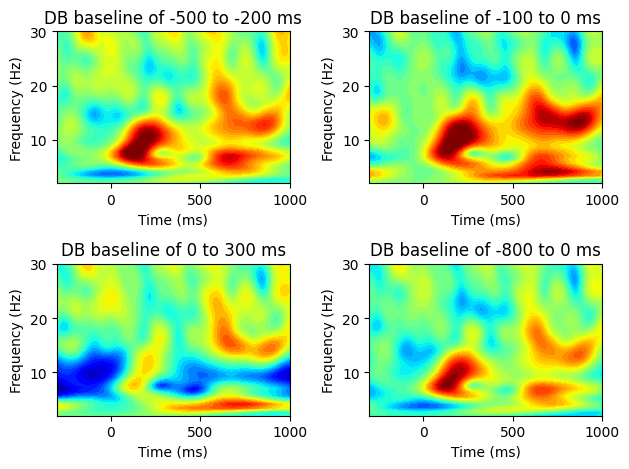

In [7]:
for basei in range(len(baseline_window)):
    plt.subplot(2, 2, basei + 1)
    plt.contourf(np.squeeze(eeg.eegtimes), frex, np.squeeze(tf[basei, :, :]),
                 40, cmap="jet", vmin=clim[0], vmax=clim[1])
    plt.xlim([-300, 1000])
    plt.title(f"DB baseline of {baseline_window[basei][0]} to {baseline_window[basei][1]} ms")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()
